## Introduction

This analysis seeks to gather valuable insight about how various home characteristics can affect sale price. It will address how common home improvements may be correlated with sale price. For example, how much can finishing your basement increase your home value? Is there any connection between the type of heating you use and the home value? Some people prefer enclosed porches to open porches - but does it impact your home value? These are all questions we will dive into deeply and seek to understand using complex inferential linear regression. 

#### Data Sources
The project combines multiple publicly available datasets [made available](https://data.kingcounty.gov/) by King County. One dataset provides a record of home and land sales alongside various identifying feautres. The second dataset gives very granular data about housing in King County, going beyond just square footage to a breakdown by room and many identifying features such as porch size, and more. Combining these two datasets opens the door for the analysis to come. 

#### The Process
1. Basic Setup and Data Assembly
2. Data Aggregation and Cleaning
3. Feature Selection and Creation
4. The Model
5. Quantify The Findings

#### Additional Notes
This notebook provides a somewhat condensed analysis compared to the full sequence necessary to understand the full details of choosing specific models and the nitty-gritty details. Please refer to the notebooks in the repository folder notebooks->exploratory if you would like to see a deep dive.


## 1. Basic Setup and Data Assembly

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import sqlite3
import os, sys
import warnings

# Import user-defined functions from Python file in this repository
path_to_figures = os.path.join('references', 'figures')
path_to_src = os.path.join('..', '..', 'src')
sys.path.insert(1, path_to_src)
from custom_functions import *
pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

sns.set(font_scale=1.0)

##### Import King County housing data

In [2]:
# Read csv files from the data directory
path = os.path.join('..','..', 'data', 'raw', 'EXTR_ResBldg.csv')
df_resbldg = pd.read_csv(path, dtype='str')

path = os.path.join('..','..', 'data', 'raw', 'EXTR_RpSale.csv')
df_rpsale = pd.read_csv(path, dtype='str')

# Use the user-defined strip_spaces function to remove leading and trailing 
# spaces from the entire dataframe
df_resbldg = strip_spaces(df_resbldg)
df_rpsale = strip_spaces(df_rpsale)

## 2. Data Aggregation and Cleaning

### The Sales Database

##### Eliminate unecessary data. After close investigation, the below columns were deemed the most worthy of continued analysis.

In [3]:
# Manual selection of the features of choice
rpsale_desired = ['ExciseTaxNbr', 'Major', 'Minor', 'DocumentDate', 
                  'SalePrice', 'RecordingNbr', 'PropertyType',  
                  'PrincipalUse', 'SaleInstrument', 'AFForestLand', 
                  'AFCurrentUseLand', 'AFNonProfitUse',  'AFHistoricProperty', 
                  'SaleReason', 'PropertyClass', 'SaleWarning']

# Remove all columns that are not in the above lists
df_rpsale = df_rpsale[rpsale_desired].copy()

##### Create identifier that will be used to connect the two dataframes. 
In this case, each database provides *Major* and *Minor*, which serve as location-specific identifiers. From here on, the combination of *Major* and *Minor* will simply be referred to as the *parcel*. Although there is often more than one sale associated with a parcel, this is a great place to start for narrowing down our search. The goal is to narrow down the *Sales* dataset to include only one sale per parcel. This allows for a connection with the second database, *Residential Buildings*. 

In [4]:
# Create ParcelID
df_rpsale['Parcel_ID'] = df_rpsale.Major + '-' + df_rpsale.Minor

##### Some of the nitty gritty data selection

**PrincipalUse:** Select only sales for "Residential" plots, corresponding to code # 6, as can be found in the data dictionary. This eliminates Commerical, Condominium, Apartment, etc.

**PropertyClass:** PropertyClass is another distinction between Commerical/Industrial and Residential, as well as other fundamental features. Code # 8 corresponds to Residential Improved property

**PropertyType:** # Yet another classification of property type. Code #11 corresponds to single family households. Here we eliminate multiple family residences, alongside many commercial uses.


In [5]:
# Actions described in text box above
df_rpsale['PrincipalUse'] = elimination_by_code(df_rpsale['PrincipalUse'], '6')
df_rpsale['PropertyClass'] = elimination_by_code(df_rpsale['PropertyClass'], '8')
df_rpsale['PropertyType'] = elimination_by_code(df_rpsale['PropertyType'], '11')

# drop na's
df_rpsale.dropna(inplace=True)

##### Limit scope to 2019 sales

In [6]:
# Type conversion
df_rpsale['DocumentDate'] = df_rpsale.DocumentDate.astype(np.datetime64)

# Isolate SaleYear as its own column
df_rpsale['SaleYear'] = [sale.year for sale in df_rpsale['DocumentDate']]

# Eliminate rows corresponding to sales in a year other than 2019
df_rpsale = df_rpsale.loc[df_rpsale['SaleYear']==2019].copy()

##### Eliminate unrealistically small sales

In [7]:
min_acceptable_sale_price = 25000
df_rpsale['SalePrice'] = df_rpsale.SalePrice.astype('int')
df_rpsale = df_rpsale.loc[df_rpsale.SalePrice > min_acceptable_sale_price].copy()

##### Create column to identify duplicates, a necessary process before combining the two datasets

In [8]:
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, 
                                  df_rpsale.Parcel_ID))

##### Upon further inspection, there are still duplicates (cases of more than one sale of a given parcel in 2019)

In [9]:
print(df_rpsale.SaleCount.value_counts())

1    17884
2      682
6        6
3        6
Name: SaleCount, dtype: int64


##### Eliminate sales that are not the most recent
This eliminates the duplicated data issue of multiple sales in one year, bringing the dataset one step closer to a unique Parcel ID

In [10]:
# User-defined function that returns True/False indicating 
# whether a sale is the most recent for each parcel
true_false = identify_latest_sale(df_rpsale.DocumentDate, 
                                  df_rpsale.Parcel_ID)
df_rpsale = df_rpsale.loc[true_false].copy()

# Recalculate 'SaleCount' after removing old sales as described above
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, 
                                  df_rpsale.Parcel_ID))
print(df_rpsale.SaleCount.value_counts())

1    18152
2      152
Name: SaleCount, dtype: int64


##### The great majority of parcels are narrowed to one sale. For the remainders, take a simple approach: average the SalePrice for all sales on that parcel. 
Further inspection was done to verify that this is a valid way of dealing with outliers. For example, in many cases, the sales are of equal or nearly equal price. 

In [11]:
# User-defined function to return the average SalePrice for each 
# parcel with more than one sale
df_rpsale = avg_price_for_duped_parcels(df_rpsale)
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, 
                                  df_rpsale.Parcel_ID))

# Remove duplicates
df_rpsale.index = df_rpsale.Parcel_ID.values
df_rpsale.drop_duplicates('Parcel_ID', inplace=True)

##### As a final step to cleaning *Sales* dataset, eliminate columns that are of no use going forward

In [12]:
# Drop unused columns as final step of cleaning before join
cols_to_keep = ['SalePrice', 'Parcel_ID', 'PropertyType', 'PrincipalUse', 
                'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 
                'AFNonProfitUse', 'AFHistoricProperty', 'SaleReason', 
                'PropertyClass', 'SaleWarning']
df_rpsale = df_rpsale[cols_to_keep].copy()
df_rpsale.head(5)

,SalePrice,Parcel_ID,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
213043-0120,560000,213043-0120,11,6,3,N,N,N,N,1,8,
940652-0630,435000,940652-0630,11,6,3,N,N,N,N,1,8,
347050-0040,648500,347050-0040,11,6,3,N,N,N,N,1,8,
345960-0230,1255000,345960-0230,11,6,3,N,N,N,N,1,8,40
030200-0645,380000,030200-0645,11,6,3,N,N,N,N,1,8,10


### The Buildings Database
This dataset requires far less cleaning than *Sales* did. In this case, it is mostly eliminating columns that have been determined not valuable as well as converting to correct datatypes.

##### Eliminate unecessary data. After close investigation, the below columns were deemed the most worthy of continued analysis.

In [13]:
# Manual selection of the features of choice
resbldg_desired = ['Major', 'Minor', 'NbrLivingUnits', 'Stories', 'BldgGrade', 
                   'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 
                   'SqFt2ndFloor','SqFtUpperFloor', 'SqFtUnfinFull', 
                   'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 
                   'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement', 
                   'SqFtGarageAttached', 'DaylightBasement','SqFtOpenPorch', 
                   'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem','HeatSource', 
                   'BrickStone', 'ViewUtilization', 'Bedrooms','BathHalfCount', 
                   'Bath3qtrCount', 'BathFullCount', 'FpSingleStory','FpMultiStory', 
                   'FpFreestanding', 'FpAdditional', 'YrBuilt','YrRenovated', 
                   'PcntComplete', 'Obsolescence', 'PcntNetCondition','Condition']

# Remove all columns that are not in above list
df_resbldg = df_resbldg[resbldg_desired].copy()

##### Create Parcel ID, which will map to Sales database 

In [14]:
# ParcelID is an aggregation of Major and Minor, as it was with the Sales database
df_resbldg['Parcel_ID'] = df_resbldg.Major + '-' + df_resbldg.Minor

##### Convert features to the appropriate data type

In [15]:
# Convert each of these columns into integer format
convert_to_int = ['SqFtOpenPorch', 'SqFtEnclosedPorch', 'Bedrooms', 
                  'SqFtGarageAttached', 'SqFtGarageBasement', 'NbrLivingUnits', 
                  'BldgGrade', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 
                  'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf',
                  'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',  
                  'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached', 
                  'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BathHalfCount',  
                  'Bath3qtrCount', 'BathFullCount', 'FpSingleStory', 'FpMultiStory', 
                  'FpFreestanding', 'FpAdditional', 'YrBuilt', 'YrRenovated', 'BrickStone']

# Loop over entire list
for category in convert_to_int:
    df_resbldg[category] = df_resbldg[category].astype('int')
    
    
# Convert into float format
df_resbldg['Stories'] = df_resbldg['Stories'].astype('float')

# Nit-picky
# Data cleaning for inconsistent casing
df_resbldg['DaylightBasement'] = df_resbldg['DaylightBasement'].str.upper() 

# Remove buildings that aren't complete
df_resbldg = df_resbldg.loc[df_resbldg.PcntComplete.astype('str') == '0'].copy() 

# Remove buildings in obsolescence process
df_resbldg = df_resbldg.loc[df_resbldg.Obsolescence.astype('str') == '0'].copy() 

# Remove 6 outliers in abnormal condition
df_resbldg = df_resbldg.loc[df_resbldg.PcntNetCondition.astype('str') == '0'].copy() 

### Combine *Sales* and *Buildings* datasets
At long last: conduct join using SQL

In [16]:
# Create a connection with a SQL DataBase file
path_to_db = os.path.join('..', '..', 'data', 'main.db')
connection = sqlite3.connect(path_to_db)
df_resbldg.to_sql('buildings', connection, if_exists='replace')
df_rpsale.to_sql('sales', connection, if_exists='replace')

# Join Sales and Buildings data together
query = '''SELECT * FROM buildings LEFT JOIN sales USING (Parcel_ID)'''
df_main = pd.read_sql(query, connection)
connection.close()

##### Remove columns that are not of interest

In [17]:
cols_to_delete = ['Major', 'Minor', 'BldgGradeVar', 'PcntComplete', 
                  'Obsolescence', 'PcntNetCondition', 'Parcel_ID', 'index', 
                  'PropertyType', 'PrincipalUse', 'SaleInstrument', 'AFForestLand',
                  'AFCurrentUseLand', 'AFNonProfitUse','AFHistoricProperty', 
                  'SaleReason', 'SaleWarning', 'index']

df_main.drop(cols_to_delete, axis=1, inplace=True)
df_main.dropna(inplace=True)
df_main

,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,SalePrice,PropertyClass
6,1,1.0,7,1480,0,0,0,0,0,1480,0,0,0,0,440,,80,0,120,5,2,0,,3,0,0,2,1,0,0,0,1994,0,5,445000.0,8
9,1,1.0,5,550,0,0,0,0,0,550,0,0,0,0,0,,0,0,0,1,1,0,,2,0,1,0,0,0,0,0,1942,0,3,188500.0,8
13,1,2.0,9,660,0,595,0,0,0,1540,380,285,8,0,0,Y,0,0,155,1,3,0,Y,3,1,1,1,0,1,0,0,1984,0,3,730000.0,8
17,1,1.0,8,1390,0,0,0,0,0,2780,1390,1390,7,0,0,Y,0,0,100,5,2,0,N,6,0,1,1,0,1,0,1,1967,0,3,1055700.0,8
22,1,1.0,8,1350,0,0,0,0,0,2230,1280,880,7,400,80,Y,40,0,100,5,3,0,,3,0,0,2,1,0,0,0,2015,0,3,565000.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178549,1,1.0,8,1290,0,0,0,0,0,1910,620,620,8,0,0,Y,70,0,100,5,2,0,N,3,1,1,1,0,0,0,0,1985,0,4,391000.0,8
178554,1,2.0,9,1410,0,1810,0,0,0,3220,0,0,0,0,630,N,0,0,0,5,2,0,N,4,0,0,3,1,0,0,0,2015,0,3,1535000.0,8
178577,1,1.5,7,830,130,0,0,0,0,960,0,0,0,0,420,,110,0,0,5,2,0,,3,0,0,1,1,0,0,0,1959,0,3,309000.0,8
178583,1,2.0,8,1250,0,760,0,0,0,2010,0,0,0,0,440,N,0,0,0,5,2,0,N,4,1,0,2,0,1,0,0,1987,0,4,759990.0,8


##### Limit study to homes with one living unit

As can be seen below, nearly all of the remaining homes have only one living unit. For the sake of consistency, limit the analysis to only single-living unit homes.

In [18]:
print('Number of homes in analysis, categorized by the number of living units:')
print(df_main.NbrLivingUnits.value_counts())

df_main = df_main.loc[df_main.NbrLivingUnits == 1].copy()
df_main.drop('NbrLivingUnits', axis=1, inplace=True)

Number of homes in analysis, categorized by the number of living units:
1    18001
2      124
3       18
Name: NbrLivingUnits, dtype: int64


## 3. Feature Selection and Creation
Using the above data, categorical inputs will be one-hot encoded such that they can be useful components of the linear regression model. Note that additional variables will be removed along this process. For the sake of keeping this notebook brief, please refer to the exploratory notebooks for further investigation

##### Understand Square Footage metrics and remove unnecessary or redundant data

In [19]:
# Add two metrics that uncompass the same idea: unfinished area of the home
df_main['SqFtUnfinished'] = df_main['SqFtUnfinFull'] + df_main['SqFtUnfinHalf']

# # Additionally, create a metric for Unfinished basement space, 
# which will be used to analyze finished vs unfinished basements 
df_main['SqFtUnfinBasement'] = df_main.SqFtTotBasement - df_main.SqFtFinBasement

# Remove SquareFootage columns determined to be redundant
sq_ft_cols_to_drop = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFtUpperFloor', 
                      'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFt2ndFloor']
df_main.drop(sq_ft_cols_to_drop, axis=1, inplace=True)

##### Aggregate *Bathroom* data
The original dataset puts bathrooms into three categories: Full, Half, and 3/4. The goal is to combine them into one column, Bathrooms. Method 1 is to count each bathroom the same, regardless of size. Method 2 is to assign them fractional counts based on their naming (1/2, 3/4). The below correlation plot shows that the results is nearly the same, a negligible difference. For the purposes of this analysis, we will use Method 2 so as to not ignore the difference in value that may be added by having a smaller bathroom (e.g. "half bath"). As we can see in the correlation plot below, the two methods are very highly correlated.

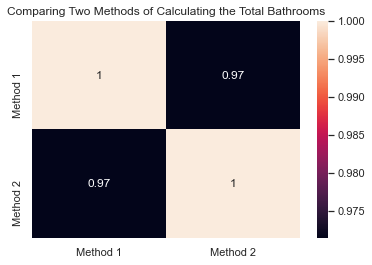

In [20]:
# Define Bathrooms for Method 1 and Method 2, as described above
bathrooms_v1 = df_main[['BathHalfCount', 'Bath3qtrCount', 
                        'BathFullCount']].sum(axis=1)
bathrooms_v2 = df_main['BathHalfCount']/2 + \
               df_main['Bath3qtrCount']*3/4 + \
               df_main['BathFullCount']

# Combine the two methods into one dataframe and visualize their correlation
bathrooms = pd.concat([bathrooms_v1, bathrooms_v2], axis=1)
bathrooms.columns = ['Method 1', 'Method 2']
corr = bathrooms.corr()
sns.heatmap(corr, annot=True)
plt.title('Comparing Two Methods of Calculating the Total Bathrooms')

# Remove columns that are now uncompassed by singluar "Bathrooms" feature
bathroom_cols_to_drop = ['BathHalfCount', 'Bath3qtrCount', 'BathFullCount']
df_main.drop(bathroom_cols_to_drop, axis=1, inplace=True)

# Add "Bathrooms" feature, Method 2, to the main dataframe to continue the analysis
df_main['Bathrooms'] = bathrooms_v2

##### Aggregate *Fireplace* data
Similar to Bathrooms, the original data source breaks down the number of Fireplaces into multiple categories: single story, multi-story, freestanding, and additional. The below code combines them into one final feature, corresponding to the total number of fireplaces. The correlation matrix is added to see how the *Total* correlates with *SalePrice*, as opposed to each individual. 
The results show the *Total Fireplaces* has a higher correlation with *SalePrice* than any of it's components. This shows that we're not ignoring potential important relationships, while also aggregating data that was disaggregated to an extent that it wouldn't be especially helpful as a result of the final analysis.

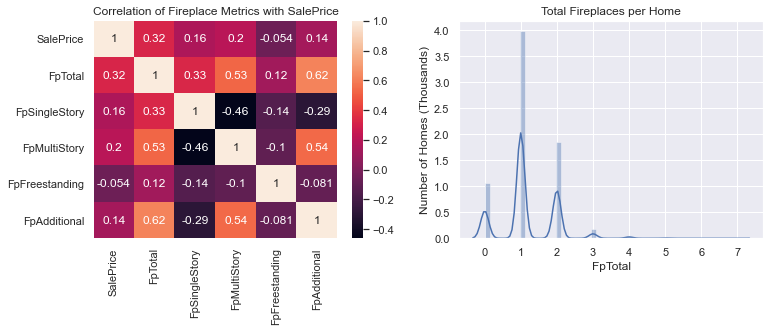

In [21]:
# Get all fireplace data in one spot and calculate the total
fireplaces = df_main[['FpSingleStory', 'FpMultiStory', 
                      'FpFreestanding', 'FpAdditional']].copy()
fireplaces['FpTotal'] = fireplaces.sum(axis=1)

# Reorder to make Correlation Matrix easier to understand
fireplaces = fireplaces[['FpTotal', 'FpSingleStory', 
                         'FpMultiStory', 'FpFreestanding', 'FpAdditional']]

# Test correlation of Total with individuals
corr = pd.concat([df_main.SalePrice, fireplaces], axis=1).corr()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.heatmap(corr, annot=True, ax=axes[0]);
axes[0].set_title('Correlation of Fireplace Metrics with SalePrice')

sns.distplot(fireplaces.FpTotal, ax=axes[1])
axes[1].set_title('Total Fireplaces per Home')
axes[1].set_ylabel('Number of Homes (Thousands)')


# Drop columns determined to be less valuable
fp_cols_to_drop = ['FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']
df_main.drop(fp_cols_to_drop, axis=1, inplace=True)
df_main['Fireplaces'] = fireplaces['FpTotal']

### One-Hot Encoding
For categorical features of interest, convert to one-hot encoded columns
#### Encode HeatSystem

In [22]:
# Convert encoded values to text values to understand their meaning
keys = get_lookups(108)
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') \
                            if x!='0' else 'Other'

heating = df_main.HeatSystem.apply(convert_to_keys)
print('Original breakdown:\n{}'.format(heating.value_counts()))

Original breakdown:
ForcedAir    14062
HeatPump      1529
ElecBB        1091
FloorWall      554
HotWater       442
Radiant        260
Gravity         38
Other           25
Name: HeatSystem, dtype: int64


##### Gravity heating is very uncommon. Lump it into the "Other" category

In [23]:
simplify = lambda x: 'Other' if x in ['Gravity'] else x
heating = heating.apply(simplify)
print('Improved categorization:\n{}'.format(heating.value_counts()))

Improved categorization:
ForcedAir    14062
HeatPump      1529
ElecBB        1091
FloorWall      554
HotWater       442
Radiant        260
Other           63
Name: HeatSystem, dtype: int64


##### One-hot encode remaining categories
Drop the ForcedAir option. Since it is by far the most common, it will be considered the default option upon which to base alternatives

In [24]:
# Create dummies
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False)

# Drop ForcedAir instead of whatever happens to be the first column
heating_dummies.drop('Heating_ForcedAir', axis=1, inplace=True) 

#Adjust df_main accordingly
df_main = pd.concat([df_main, heating_dummies], axis=1)
df_main.drop(['HeatSystem', 'Heating_Other'], axis=1, inplace=True)

#### Encode Condition
Follow process similar to HeatSystem to represent categorical *Condition* feature. Drop the *Average* option since it is naturally a baseline

In [25]:
# Convert numerical encoding to actual values
keys = get_lookups(83)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)

##### Plot a breakdown to show commonality of categories

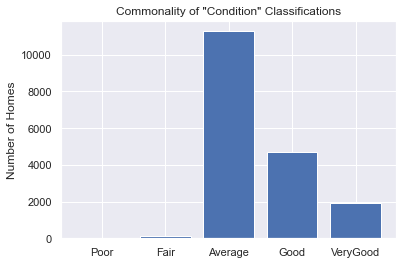

In [26]:
condition_cts = pd.DataFrame(condition.value_counts()).T.reset_index(drop=True)

# Reorder
new_order = ['Poor', 'Fair', 'Average', 'Good', 'VeryGood']
condition_cts = condition_cts[new_order].T

# Plot
plt.bar(condition_cts.index, condition_cts.iloc[:, 0])
plt.title('Commonality of "Condition" Classifications')
plt.ylabel('Number of Homes');

##### One-hot encode Condition

In [27]:
# Create dummies
condition_dummies = pd.get_dummies(condition, prefix='Condition', 
                                   drop_first=False)

# Drop Average instead of whatever happens to be the first column
condition_dummies.drop('Condition_Average', axis=1, inplace=True)

#Adjust df_main accordingly
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

#### Encode Porch
By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether its presence impacts SalePrice. Encoded as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [28]:
# Create separate DataFrame to temporarily hold Porch data
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else \
                             'Open' if x.Open>0 else \
                             'Closed' if x.Encl>0 else 'None'

porches['Porch'] = porches.apply(classify_porches, axis=1)

##### Visualize the commonality of Porches
As we can see, Open porches are by far the most common type, but it is just as common for a home to not have a porch at all.

Commonality of Porches
         Porch
Open     8732
None     8532
Closed    417
Both      320


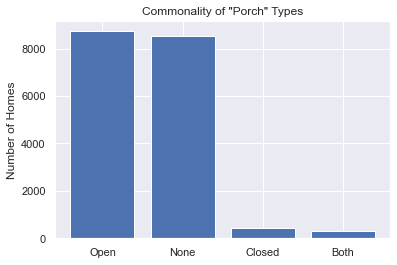

In [29]:
porch_cts = pd.DataFrame(porches.Porch.value_counts())

print('Commonality of Porches\n', porch_cts)
plt.bar(porch_cts.index, porch_cts.Porch)
plt.title('Commonality of "Porch" Types')
plt.ylabel('Number of Homes');

##### One-hot encode Porch types

In [30]:
porches_dummies = pd.get_dummies(porches['Porch'], prefix='Porch', 
                                 drop_first=False)
porches_dummies.drop('Porch_None', axis=1, inplace=True)

# Adjust df_main accordingly
df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)

#### Create binary column for whether a home has been renovated

In [31]:
encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)

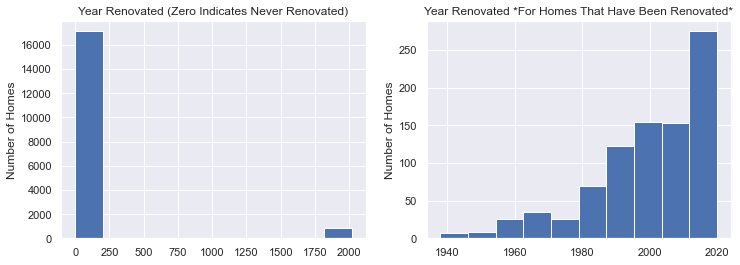

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(df_main.YrRenovated)
axes[0].set_title("Year Renovated (Zero Indicates Never Renovated)")
axes[0].set_ylabel('Number of Homes');

axes[1].hist(df_main.loc[df_main.YrRenovated>0, 'YrRenovated'])
axes[1].set_title('Year Renovated *For Homes That Have Been Renovated*')
axes[1].set_ylabel('Number of Homes');

##### Add binary indication of renovation (1 = "yes", 0 = "no)

In [33]:
encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)

#### Create binary column for whether a home's basement is finished

In [34]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']
classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else \
                               'Finished' if x.fin>0 else \
                               'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)

##### Plot commonality of whether a basement is finished, unfinished, or simply does not exist

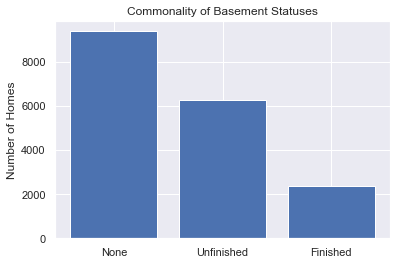

In [35]:
basement_cts = pd.DataFrame(basement.Simplified.value_counts())
plt.bar(basement_cts.index, basement_cts.Simplified)
plt.title('Commonality of Basement Statuses')
plt.ylabel('Number of Homes');

In [36]:
basement_cts

,Simplified
None,9375
Unfinished,6264
Finished,2362


In [37]:
2362/(2362+6264)

0.2738233248319035

In [38]:
# One-hot encode
basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', 
                                  drop_first=False)

# Drop 'Unfinished' to set it as the default when investigating 
# the impact of finishing the basement
basement_dummies.drop('Basement_Unfinished', axis=1)

df_main = pd.concat([df_main, basement_dummies], axis=1)
df_main.drop('Basement_None', axis=1, inplace=True)

##### Misc. cleanup

In [39]:
# Reset index
df_main.reset_index(inplace=True, drop=True)

# Move dependent variable to first column to make future graphs more comprehensible
df_main = pd.concat([df_main['SalePrice'], df_main.drop('SalePrice', axis=1)], axis=1)

## 4. The Model
Below is an investigation of modeling the above-formulated data via inferential linear regression. Only the first and final models are included for the sake of brevity. For a full investigation of the impact of adding specific features, please review the previously referenced Exploratory notebooks.

### Understanding the Data
##### In table format

In [40]:
df_main

,SalePrice,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtDeck,HeatSource,BrickStone,ViewUtilization,Bedrooms,YrBuilt,YrRenovated,PropertyClass,SqFtUnfinished,SqFtUnfinBasement,Bathrooms,Fireplaces,Heating_ElecBB,Heating_FloorWall,Heating_HeatPump,Heating_HotWater,Heating_Radiant,Condition_Fair,Condition_Good,Condition_Poor,Condition_VeryGood,Porch_Both,Porch_Closed,Porch_Open,Renovated,Basement_Finished,Basement_Unfinished
0,445000.0,1.0,7,1480,0,0,0,0,440,,120,2,0,,3,1994,0,8,0,0,2.00,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,188500.0,1.0,5,550,0,0,0,0,0,,0,1,0,,2,1942,0,8,0,0,0.75,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,730000.0,2.0,9,1540,380,285,8,0,0,Y,155,3,0,Y,3,1984,0,8,0,95,2.25,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1055700.0,1.0,8,2780,1390,1390,7,0,0,Y,100,2,0,N,6,1967,0,8,0,0,1.75,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,565000.0,1.0,8,2230,1280,880,7,400,80,Y,100,3,0,,3,2015,0,8,0,400,2.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,391000.0,1.0,8,1910,620,620,8,0,0,Y,100,2,0,N,3,1985,0,8,0,0,2.25,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
17997,1535000.0,2.0,9,3220,0,0,0,0,630,N,0,2,0,N,4,2015,0,8,0,0,3.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17998,309000.0,1.5,7,960,0,0,0,0,420,,0,2,0,,3,1959,0,8,0,0,1.00,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
17999,759990.0,2.0,8,2010,0,0,0,0,440,N,0,2,0,N,4,1987,0,8,0,0,2.50,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [41]:
print('List of columns remaining for analysis:', list(df_main.columns))

List of columns remaining for analysis: ['SalePrice', 'Stories', 'BldgGrade', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement', 'SqFtDeck', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms', 'YrBuilt', 'YrRenovated', 'PropertyClass', 'SqFtUnfinished', 'SqFtUnfinBasement', 'Bathrooms', 'Fireplaces', 'Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump', 'Heating_HotWater', 'Heating_Radiant', 'Condition_Fair', 'Condition_Good', 'Condition_Poor', 'Condition_VeryGood', 'Porch_Both', 'Porch_Closed', 'Porch_Open', 'Renovated', 'Basement_Finished', 'Basement_Unfinished']


##### Graphical: Distribution relationships between features
The below pair-plot shows only continous features. Features with a small number of values don't provide much meaning in this graph. It is also a slow function, which is made slower by including all features.

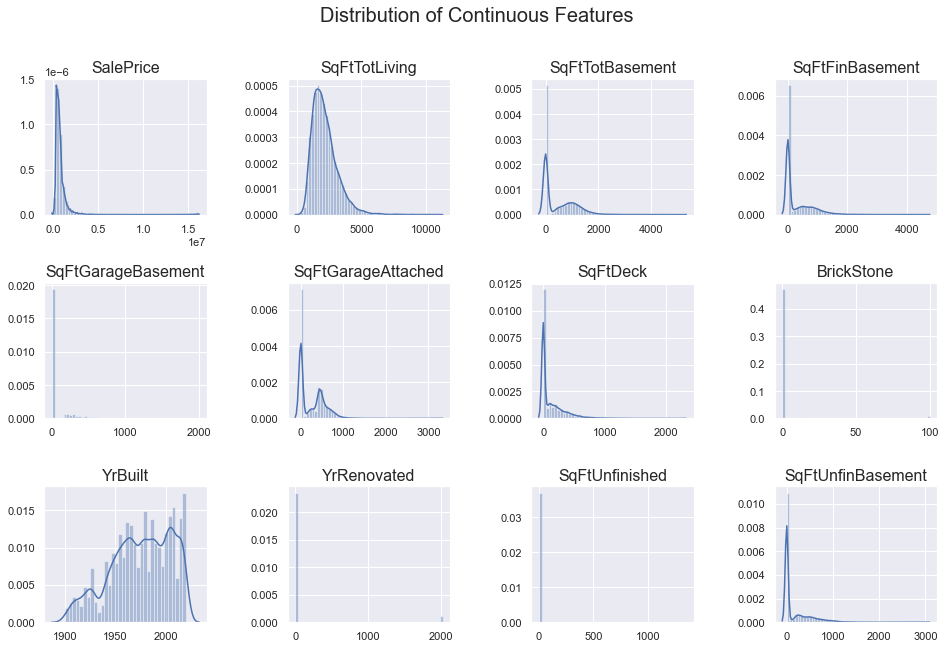

In [42]:
# Ignore Seaborn warnings (previously been determined non-consequential)
warnings.filterwarnings("ignore")


# User-defined function that isolates inputs with a minimum number 
# of distinct observations
continuous_features = identify_continuous_features(df_main)

# Distribution Plots for above-derived features
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for col, ax in zip(continuous_features.columns, axes.flatten()):
    sns.distplot(continuous_features[col], ax=ax)
    ax.set_title(col, fontsize=16)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=.5, hspace=.5)
fig.suptitle('Distribution of Continuous Features', fontsize=20)


name = 'Distribution_of_Continuous_Features.png'
path = os.path.join('..', '..', 'references', 'figures', name)
fig.savefig(path)

#### Graphical: Correlations

##### Heat map for continuous features (as defined above)

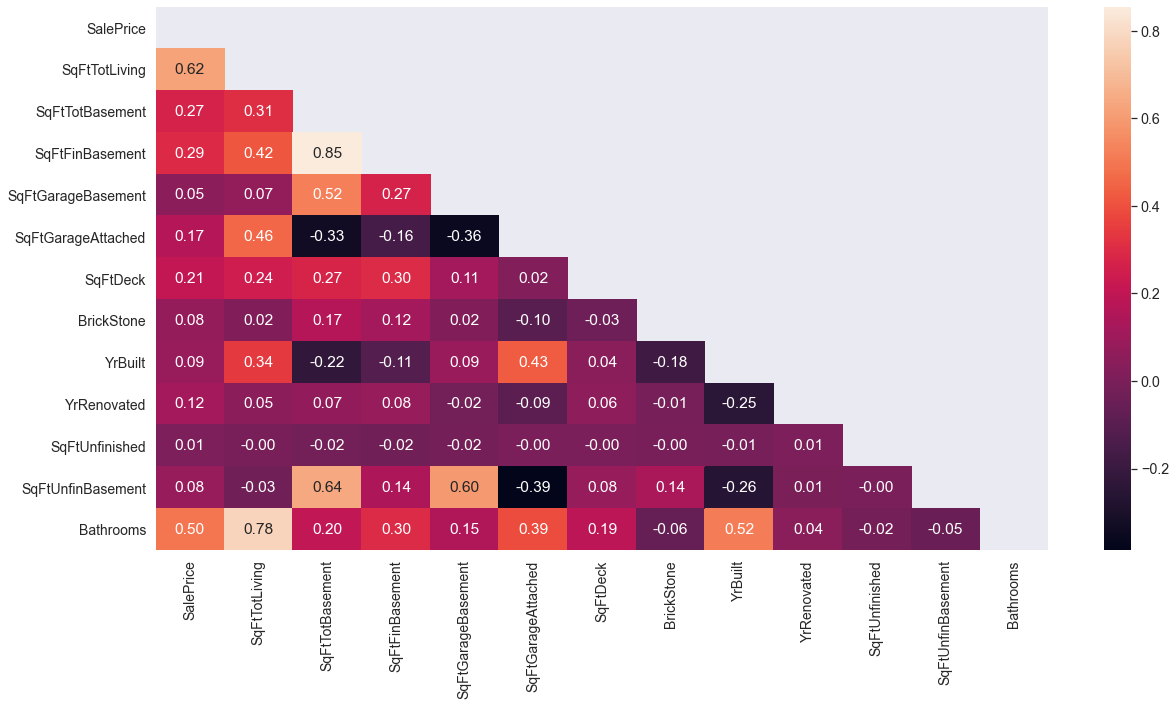

In [43]:
sns.set(font_scale=1.3)
corr = continuous_features.corr()

# Formula taken from Flatiron School study group material
mask = np.triu(np.ones_like(corr, dtype=np.bool)) 
fig, ax = plt.subplots(figsize=(20, 10))
heatmap = sns.heatmap(corr, mask=mask, ax=ax, annot=True, fmt='.2f')



# Save image to be used externally
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 14)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 14)
name = 'correlations_continuous.png'
path = os.path.join('..', '..', 'references', 'figures', name)
fig.savefig(path)

##### Heat map for features with few distinct inputs (i.e. those note above), plotted with SalePrice

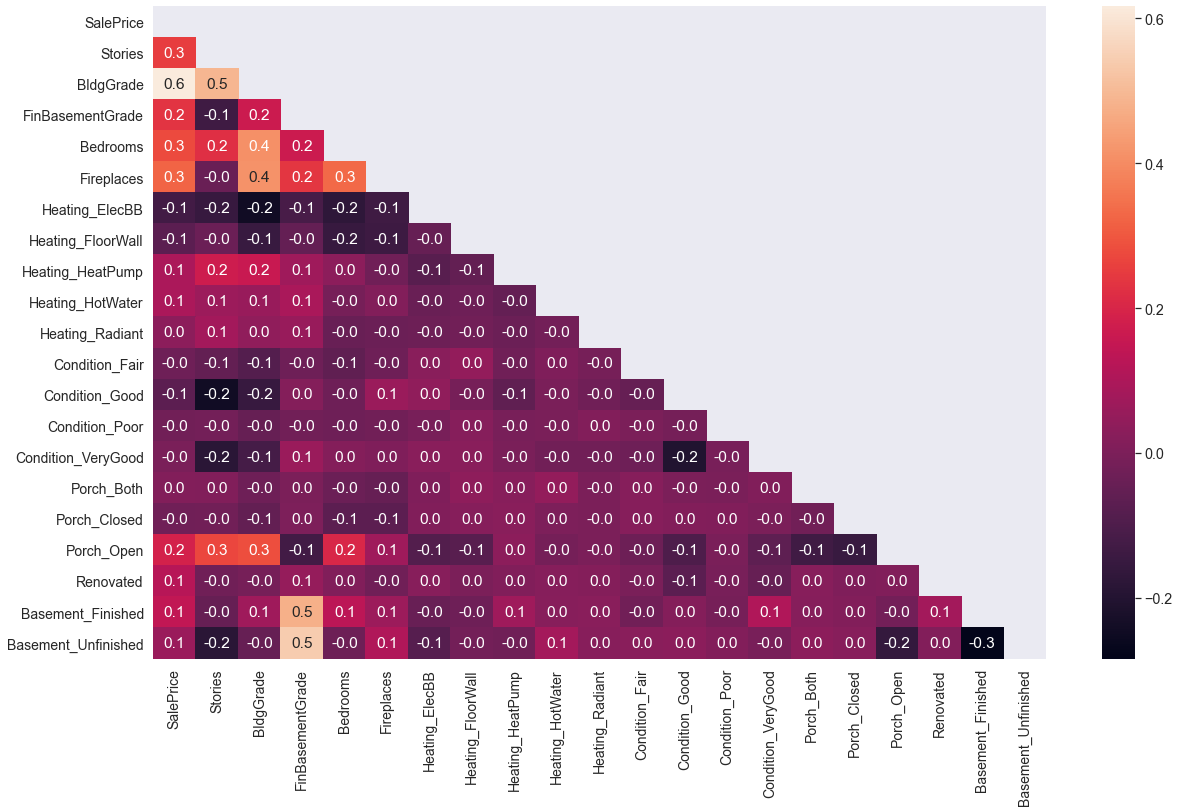

In [44]:
df_discrete = pd.concat([df_main.SalePrice, 
                         df_main.drop(continuous_features.columns, axis=1)], 
                         axis=1)

corr = df_discrete.corr()

# Formula taken from Flatiron School study group material
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig, ax = plt.subplots(figsize=(20, 12))
heatmap = sns.heatmap(corr, mask=mask, ax=ax, annot=True, fmt='.1f');


# Save image to be used externally
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 14)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 14)
name = 'correlations_discrete.png'
path = os.path.join('..', '..', 'references', 'figures', name)
fig.savefig(path)

sns.set(font_scale=1.0)

##### List correlations of SalePrice and input features

In [45]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & 
                                (correlations.level_1 != 'SalePrice')]

correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()

correlations.sort_values(by='Correlation (abs)', ascending=False, 
                         inplace=True, ignore_index=True)
print(correlations)

    Dependent              Feature  Correlation (abs)
0   SalePrice        SqFtTotLiving           0.622964
1   SalePrice            BldgGrade           0.616661
2   SalePrice            Bathrooms           0.497153
3   SalePrice           Fireplaces           0.324652
4   SalePrice      SqFtFinBasement           0.293986
5   SalePrice             Bedrooms           0.277142
6   SalePrice      SqFtTotBasement           0.271466
7   SalePrice              Stories           0.252528
8   SalePrice     FinBasementGrade           0.235934
9   SalePrice             SqFtDeck           0.208758
10  SalePrice           Porch_Open           0.190711
11  SalePrice   SqFtGarageAttached           0.170354
12  SalePrice    Basement_Finished           0.142429
13  SalePrice       Heating_ElecBB           0.127042
14  SalePrice          YrRenovated           0.121847
15  SalePrice            Renovated           0.121633
16  SalePrice     Heating_HeatPump           0.099330
17  SalePrice     Heating_Ho

### The Baseline Model
After reviewing the above table, we see that Livable Square Footage is the highest predictor or Sale Price. This isn't surprising. Let's create the simple model and check the assumptions of Linear Regression. Let's also create a dataframe to store the model performance metrics so we can compare them as we go.

In [46]:
performance_metrics_cols = ['Y', 'X', 'Linearity p-value', 'Jarque-Bera (JB) metric', 
                            'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 
                            'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']

performance_metrics = pd.DataFrame(columns = performance_metrics_cols)

Modeling: SalePrice ~ SqFtTotLiving
Linearity p-value (where null hypothesis = linear): 3.587071216944482e-06
Normality of Residuals (where null hypothesis = normality): JB stat=13168580.776817815, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=2.862987888289054e-95 and f-value's p-value=2.1878385775370354e-96
Variance Inflation Factors: NA (single variable)
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 1.142e+04
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:52:28   Log-Likelihood:            -2.6030e+05
No. Observations:               18001   AIC:                         5.206e+05
Df Residuals:                   17999   B

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000004,1.316858e+07,0.0,428.870063,2.862988e-95,439.288367,2.187839e-96,NA,0.38805


<Figure size 432x288 with 0 Axes>

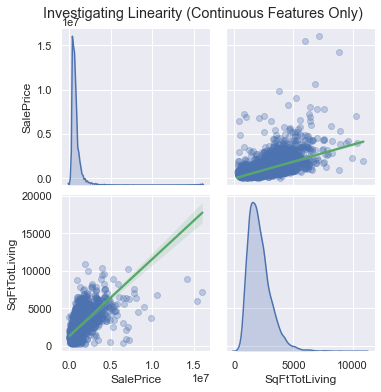

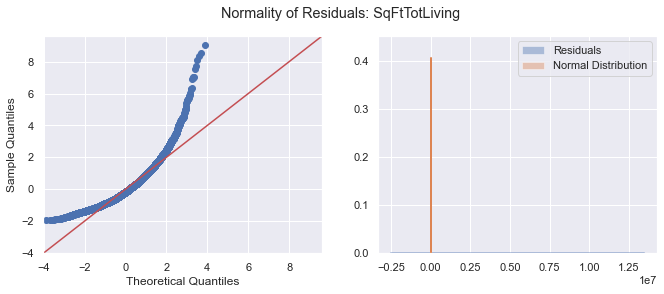

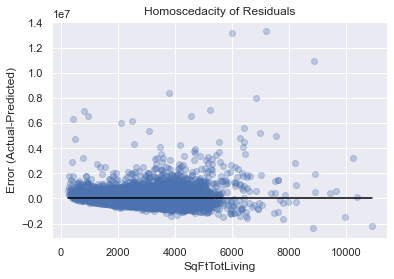

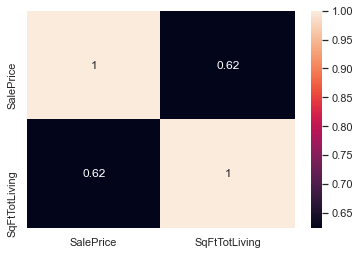

In [47]:
inputs = ['SqFtTotLiving']
output = 'SalePrice'

model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, 
                            feature_to_plot='SqFtTotLiving')

print(model.summary())
performance_metrics = performance_metrics.append(results)
performance_metrics

##### Analysis of above model
As we can see, it's not linear. In fact, only one of the necessary fundamental assumptions is met. That said, it is impossible to not meet given one input feature. That is of course Multicollinearity. We see that in the Variance Inflation Factor (VIF) producing an NA. All other statistics are especially bad:
1. **Linearity: failed.** The inputs are not linear, as described by the linear rainbow test. A p-value greater than 0.05 would indicate linearity. This model produces a p-value of 0.000004. Not good.
2. **Normality of Residuals: failed.** The model residuals are not normally distributed. This is seen in the QQ-plot and the Jarque-Bera (JB) metric and its associated p-value. Although the metric would ideally be less than 5 and the p-value would be greater than 0.05, we instead have a metric equal to 13168580 and a p-value equal to effectively 0. Not good.
3. **Homoscedacity: failed.** The residuals are not homoscedastic. This is visualized in the scatter plot above and quantified by the F-score and its associated p-value. Lower F-scores are better, and the p-value should be above 0.05. Instead, the F-score in 439 and the associated p-value is 2.18e-96. Not good.
4. **Multi-collinearity: passed by default.** this is inherently not an issue as discussed above solely because there is only one input, thus making collinearity impossible. 

### Final Model

We see that there are extensive improvements to be made to the above model. For a full walk-through of the discovery process of getting to this final model, please review the Exploratory notebooks. In brief, here are some improvements made to the model:
1. SalePrice is log-transformed. We can see in the distribution plot above that there is a severe skew to the SalePrice data. This is nearly entirely reconciled by log-transforming the output, as is done in the final model.
2. SqFtTotLiving is also log-transformed for a very similar reason. It improves linearity drastically. 
3. Binary feature corresponding to whether or not the basement has been finished was added.
4. One-hot encoded features corresponding to the porch are added, measuring the impact of an Open porch, and Enclosed porch, or Both.
5. One-hot encoded features corresponding to the type of heating used in the home are added. 

As a result, all performance metrics have improved.

##### Log-transform SqFtLivingArea and SalePrice

In [48]:
log_transform = lambda x: np.log(x)    
df_main['SalePrice_log'] = df_main.SalePrice.apply(log_transform)
df_main['SqFtTotLiving_log'] = df_main.SqFtTotLiving.apply(log_transform)

##### (move this down)

##### Analysis of the final model
There have in fact been substantial improvements in all metrics necessary to meet the fundamental assumptions of linear regression. Two of four have reached the necessary threshold. The other two have not, but have got closer.
1. **Linearity: passed.** The linearity assumption is met because the p-value associated with the linear rainbow test is 0.37, far above the predetermined 0.05 alpha threshold required. This improvement came largely from log-transforming the SalePrice and the SqFtLivingArea, however, there were plenty of features that were tested in the model development process that were excluded in part because they pummeled the linearity p-value.
2. **Normality of Residuals: failed.** The normality of residuals, measured by the JB metric and p-value, have a ways to go. The JB stat decreased from 1.3e7 to 6300. This is a huge improvement, but the associated p-value still rounds to zero, meaning it is far from checking the box.
3. **Homoscedacity: failed but *almost* passed.** The plot above shows only the residuals for SqFtTotLiving, but there are drastic improvements in the F-scoe, Langrange multiplier, and their associated p-values. For example, the p-value for the score increased from 2e-96 to 0.009. That leaves the p-value less than one order of magnitude away from meeting the requirement. Although it isn't success, it's a huge step.
4. **Multi-collinearity: passed** The multi-collinearity assumption, as measured by VIF metrics is met. The average VIF is roughly 1.3. Given that anything below 5 is considered passable, this one is a pass. 



Modeling: SalePrice_log ~ SqFtTotLiving_log+Basement_Finished+Porch_Open+Porch_Closed+Porch_Both+Heating_ElecBB+Heating_FloorWall+Heating_HeatPump+Heating_HotWater+Heating_Radiant
Linearity p-value (where null hypothesis = linear): 0.3368077235007223
Normality of Residuals (where null hypothesis = normality): JB stat=6315.776237293339, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.009017863752960917 and f-value's p-value=0.00899846543476936
Variance Inflation Factors:
              Feature       VIF
0  SqFtTotLiving_log  2.683602
1  Basement_Finished  1.172284
2         Porch_Open  2.125408
3       Porch_Closed  1.048950
4         Porch_Both  1.042409
5     Heating_ElecBB  1.076525
6  Heating_FloorWall  1.041742
7   Heating_HeatPump  1.118834
8   Heating_HotWater  1.035079
9    Heating_Radiant  1.018632
                            OLS Regression Results                            
Dep. Variable:          SalePrice_log   R-squared:        

,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000004,1.316858e+07,0.0,428.870063,2.862988e-95,439.288367,2.187839e-96,NA,0.388050
0,SalePrice_log,SqFtTotLiving_log+Basement_Finished+Porch_Open...,0.336808,6.315776e+03,0.0,23.508388,9.017864e-03,2.352474,8.998465e-03,1.33635,0.399915


<Figure size 432x288 with 0 Axes>

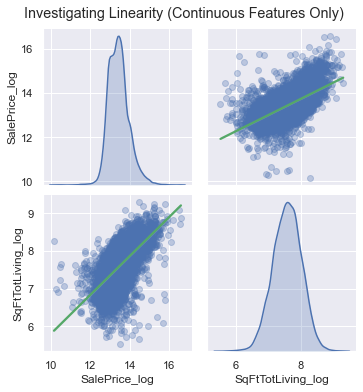

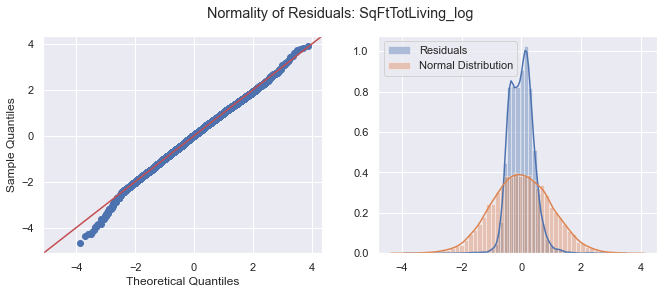

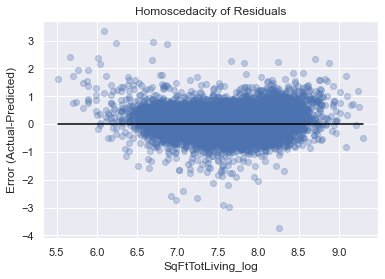

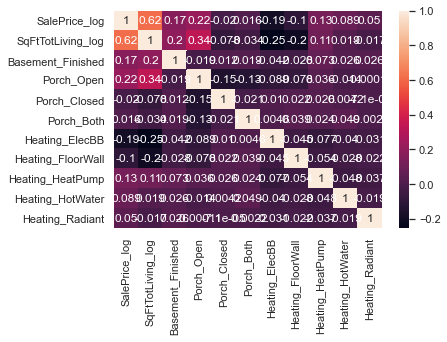

In [49]:
# Define model inputs and output
inputs = ['SqFtTotLiving_log', 'Basement_Finished', 'Porch_Open', 
          'Porch_Closed', 'Porch_Both', 'Heating_ElecBB', 'Heating_FloorWall', 
          'Heating_HeatPump', 'Heating_HotWater','Heating_Radiant']
output = 'SalePrice_log'

# Run user-defined functions to create model and subsequently 
# check the assumptions of linear regression
model, df_model = produce_model(df_main, inputs, output)
results = check_assumptions(model, df_model, output, verbose=True, 
                            feature_to_plot='SqFtTotLiving_log')

print(model.summary())
performance_metrics = performance_metrics.append(results)
performance_metrics

## 5. Quantify The Findings

#### Quantify the import of coefficients given log-scaled output: create DataFrame with results
##### Create column to indicate whether a feature was log-transformed

In [50]:
results = pd.DataFrame(model.params).reset_index()
results.columns = ['attribute', 'coeff']
results['log_transformed?'] = ['_log' in x for x in results.attribute]

##### For feature that **were not** log transformed: calculate the "Percent change in SalePrice per *UNIT* input increase"

In [51]:
# Reverse log calculation
exp_func = lambda x: np.round(10**x, 2)-1
results['% change in SalePrice per *unit* input increase'] = results['coeff'].apply(exp_func)

# Set intercept equal to NA as it cannot be interpretted this way
results.iloc[0, -1] = 'NA'

# Set features that *were* log transformed equal to NA. They need their own column
results.loc[results['log_transformed?']==True, \
            '% change in SalePrice per *unit* input increase'] = 'NA'

##### For feature that **were** log transformed: calculate the "Percent change in SalePrice per *PERCENT* input increase"

In [52]:
# Store converted values
logged_inputs_converted = []

# Loop over all features
for row in range(results.shape[0]):
    
    # Enter statement if a feature was log transformed
    if results.iloc[row]['log_transformed?'] == True:
        
        # 1.01 corresponds to a 1% increase
        x = 1.01**results.iloc[row]['coeff']
        logged_inputs_converted.append(x-1)
    
    else:
        # This is not a valid metric for inputs that weren't transformed. Set to NA
        logged_inputs_converted.append('NA')
results['% change in SalePrice per *percent* input increase']  = logged_inputs_converted

In [53]:
results

,attribute,coeff,log_transformed?,% change in SalePrice per *unit* input increase,% change in SalePrice per *percent* input increase
0,Intercept,8.041623,False,NA,NA
1,SqFtTotLiving_log,0.705046,True,NA,0.0070401
2,Basement_Finished,0.071726,False,0.18,NA
3,Porch_Open,0.034408,False,0.08,NA
4,Porch_Closed,0.101043,False,0.26,NA
5,Porch_Both,0.133224,False,0.36,NA
6,Heating_ElecBB,-0.057129,False,-0.12,NA
7,Heating_FloorWall,0.081217,False,0.21,NA
8,Heating_HeatPump,0.113187,False,0.3,NA
9,Heating_HotWater,0.267591,False,0.85,NA


### Findings

#### Enclose the porch
Take note of the **Porch_** metrics in the *Results* table. Note that these are one-hot encoded, with the default being no porch at all. To put it into context, homes with *Open* porches tend to sell for roughly 8% more than homes without a porch at all. However, that number jumps to 27% for homes with *Enclosed* porches, meaning that homes with *enclosed* porches sell for nearly 20% more than homes with *open* porches. It looks like it's time to enclose that porch of yours!

#### Finish the basement
Refer to the **Basement_Finished** row in the *Results* table. This is one-hot encoded to indicate whether or not a basement is finished or unfinished. Note that this excludes homes with no basement at all. As we can see, homes with finished basements typically sell for 18% more than homes with unfinished basements. Maybe it's worth the time and money to get it finished up. 

#### Consider a new heating system
Refer to the **Heating_** rows in the *Results* table. These are one-hot encoded values, with the default being Forced Air, given that it is by far the most common. It is used in over 75% of the 18,000 homes analyzed. Here, the results are unrealistically extreme. Instead of looking at the degree to which a heating system can impact home price, let's instead view it as a *trend*. The heating sources in the most expensive sales are Radiant and Hot Water. Heat pump and Floor-Wall are also correlated with a higher price than Forced Air. Coming in last, Electric Baseboard heating is associated with the lowest sale prices of homes. 

#### Consider an add-on
Amongst the strongest predictors of sale price is the **Livable Square Feet** in a home. This is not surprising. The relationship is striking: for every 10% increase in square footage, there is a 7% increase in home value. 